In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [3]:
# Data from https://github.com/pcm-dpc/COVID-19 (Protezione civile)
# (repo should be cloned in directory 'protezione-civile' for the following to work)
df = pd.read_csv("protezione-civile/COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv", index_col=0)
df.index = pd.to_datetime(df.index)
x_data = np.arange(len(df)) + 1

cases_last_date =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)

In [4]:
df [:5]

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
data,,,,,,,,,,,,,
2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324,NaN,NaN
2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623,NaN,NaN
2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587,NaN,NaN
2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014,NaN,NaN
2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695,NaN,NaN


In [5]:
df[-5:]

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
data,,,,,,,,,,,,,
2020-03-22 17:00:00,ITA,19846,3009,22855,23783,46638,3957,7024,5476,59138,258402,NaN,NaN
2020-03-23 17:00:00,ITA,20692,3204,23896,26522,50418,3780,7432,6077,63927,275468,NaN,NaN
2020-03-24 17:00:00,ITA,21937,3396,25333,28697,54030,3612,8326,6820,69176,296964,NaN,NaN
2020-03-25 17:00:00,ITA,23112,3489,26601,30920,57521,3491,9362,7503,74386,324445,NaN,NaN
2020-03-26 17:00:00,ITA,24753,3612,28365,33648,62013,4492,10361,8165,80539,361060,NaN,NaN


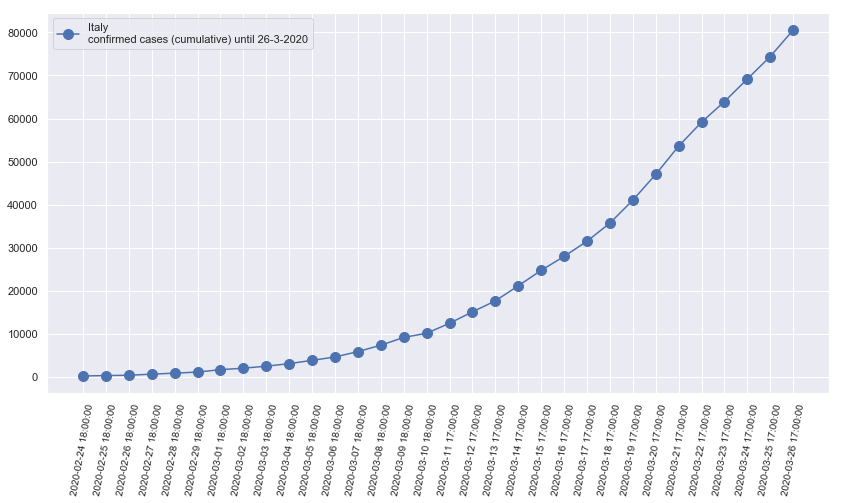

In [6]:
fig1 = plt.figure(figsize=(14, 7))
splt1 = fig1.add_subplot(111)

splt1.plot(x_data, df['totale_casi'], '-o',
           markersize=10,
           label = f"Italy\nconfirmed cases (cumulative) until {cases_last_date}")

plt.xticks(ticks=x_data, labels=df.index, rotation=80, size = 10)
plt.legend()

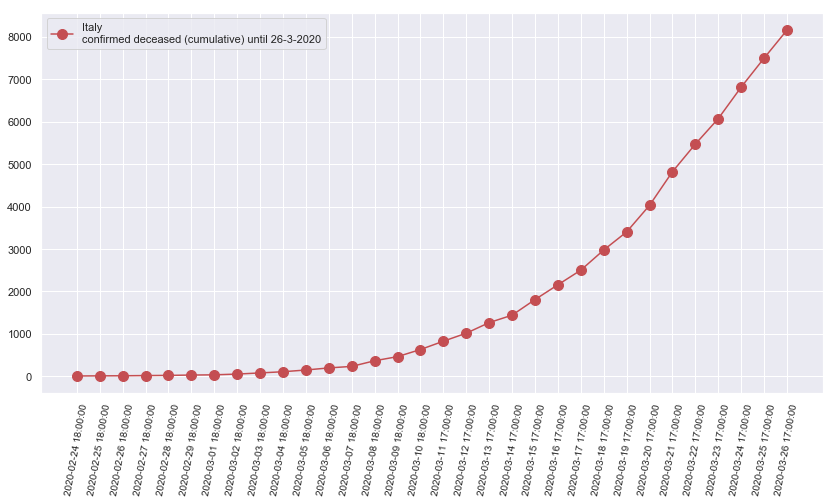

In [7]:
fig2 = plt.figure(figsize=(14, 7))
splt2 = fig2.add_subplot(111)

splt2.plot(x_data, df['deceduti'], '-o',
           markersize=10, c = 'r',
           label = f"Italy\nconfirmed deceased (cumulative) until {cases_last_date}")

plt.xticks(ticks=x_data, labels=df.index, rotation=80, size = 10)
plt.legend()

In [8]:
def logistic_funct(x, params):
    k = params[0]   # steepness 
    l = params[1]   # maximum value
    x0 = params[2]  # sigmoid's midpoint (0 for x-axis simmetry)
    return l / (1 + np.exp(-(x - x0) * k))

def mod_logistic_funct(x, params):
    i = params[0]
    a = params[1]
    d = params[2]
    p = params[3]
    K = np.exp((np.log(2.0)*(x - a)) / d)
    return (i + (K / (1 + K / p)))

def gompertz_funct(x, params):
    a = params[0]   # asymptote 
    k = params[1]   # growth rate
    x0 = params[2]  # inflection midpoint
    return a * (np.exp(-np.exp(-(x - x0) * k)))

In [9]:
def logistic_residuals(params, x, y):
    return logistic_funct(x, params) - y

def mod_logistic_residuals(params, x, y):
    return mod_logistic_funct(x, params) - y

def gompertz_residuals(params, x, y):
    return gompertz_funct(x, params) - y

# Confirmed cases
Column `totale_casi`:

First 5:

In [10]:
print(df['totale_casi'].head(5))

data
2020-02-24 18:00:00    229
2020-02-25 18:00:00    322
2020-02-26 18:00:00    400
2020-02-27 18:00:00    650
2020-02-28 18:00:00    888
Name: totale_casi, dtype: int64


Last 5:

In [11]:
print(df['totale_casi'].tail(5))

data
2020-03-22 17:00:00    59138
2020-03-23 17:00:00    63927
2020-03-24 17:00:00    69176
2020-03-25 17:00:00    74386
2020-03-26 17:00:00    80539
Name: totale_casi, dtype: int64


In [12]:
initial_params = [0.4, 70000.0, 22.0]

res_lsq_1 = least_squares(logistic_residuals, initial_params, args=(x_data[:-1], df['totale_casi'][:-1]))
res_lsq_2 = least_squares(logistic_residuals, initial_params, args=(x_data[:-2], df['totale_casi'][:-2]))
res_lsq_3 = least_squares(logistic_residuals, initial_params, args=(x_data[:-3], df['totale_casi'][:-3]))
res_lsq_4 = least_squares(logistic_residuals, initial_params, args=(x_data[:-4], df['totale_casi'][:-4]))
res_lsq   = least_squares(logistic_residuals, initial_params, args=(x_data, df['totale_casi']))

In [13]:
print("Linear loss")
print("steepness =", res_lsq.x[0], "- Maximum value =", res_lsq.x[1], "- Mid point =", res_lsq.x[2])

Linear loss
steepness = 0.19427323097963184 - Maximum value = 116673.02182695993 - Mid point = 27.988352692917182


([<matplotlib.axis.XTick at 0x21113f91828>,
 <a list of 50 Text xticklabel objects>)

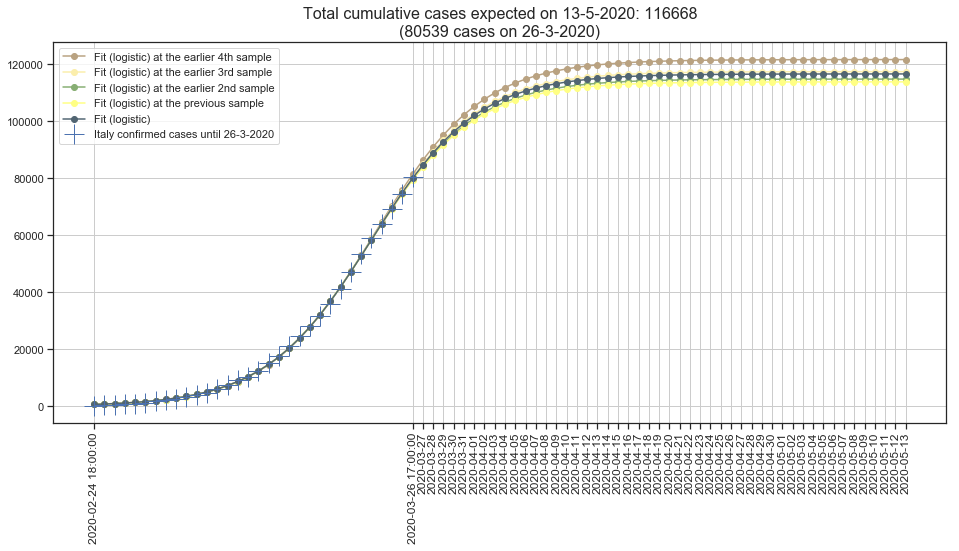

In [14]:
sns.set(style="ticks")

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(111)

cases_last_date =  str(df.index[-1].day) + "-" + str(df.index[-1].month) + "-" + str(df.index[-1].year)

x_longer = np.arange (2.5 * len(x_data)) + 1

# Fit on data
fit_cases = logistic_funct(x_longer, res_lsq.x)
fit_cases_1 = logistic_funct(x_longer, res_lsq_1.x)
fit_cases_2 = logistic_funct(x_longer, res_lsq_2.x)
fit_cases_3 = logistic_funct(x_longer, res_lsq_3.x)
fit_cases_4 = logistic_funct(x_longer, res_lsq_4.x)

ax.plot(x_longer, fit_cases_4, 'o-', c = sns.xkcd_rgb["taupe"], label="Fit (logistic) at the earlier 4th sample")
ax.plot(x_longer, fit_cases_3, 'o-', c = sns.xkcd_rgb["light tan"], label="Fit (logistic) at the earlier 3rd sample")
ax.plot(x_longer, fit_cases_2, 'o-', c = sns.xkcd_rgb["sage"], label="Fit (logistic) at the earlier 2nd sample")
ax.plot(x_longer, fit_cases_1, 'o-', c = sns.xkcd_rgb["pale yellow"], label="Fit (logistic) at the previous sample")
ax.plot(x_longer, fit_cases, 'o-', c = sns.xkcd_rgb["slate"], label="Fit (logistic)")
ax.plot(x_data, df['totale_casi'], '+', markersize=20, label = f"Italy confirmed cases until {cases_last_date}")

expected_final = int(np.round(fit_cases[-1]))
last_confirmed = df['totale_casi'][-1]
final_date = df.index[0] + (len(x_longer) - 1) * (df.index[1] - df.index[0])
final_date_fmt = str(final_date.day) + "-" + str(final_date.month) + "-" + str(final_date.year) 
plt.title(f"Total cumulative cases expected on {final_date_fmt}: {expected_final}\n({last_confirmed} cases on {cases_last_date})", size=16)
plt.legend()
plt.grid()

future_range = np.arange(len(df), 2.5 * len(df) + 1)
future_range_labels = [str(df.index[0]), str(df.index[-1])]
for dt in pd.date_range(df.index[-1], df.index[-1] + len(future_range) * (df.index[-1] - df.index[-2])):
    if dt > df.index[-1]:
        future_range_labels += [str(dt.year) + "-" + f'{dt.month:02}' + "-" + f'{dt.day:02}']

plt.xticks(ticks = np.concatenate([[1], future_range]),
           labels = future_range_labels,
           rotation = 90, size = 12)

# Confirmed deceased
Column `deceduti`:

First 5:

In [15]:
print(df['deceduti'].head(5))

data
2020-02-24 18:00:00     7
2020-02-25 18:00:00    10
2020-02-26 18:00:00    12
2020-02-27 18:00:00    17
2020-02-28 18:00:00    21
Name: deceduti, dtype: int64


Last 5:

In [16]:
print(df['deceduti'].tail(5))

data
2020-03-22 17:00:00    5476
2020-03-23 17:00:00    6077
2020-03-24 17:00:00    6820
2020-03-25 17:00:00    7503
2020-03-26 17:00:00    8165
Name: deceduti, dtype: int64


In [17]:
initial_params = [0.2, 11000.0, 20.0]

res_lsq_d_1 = least_squares(logistic_residuals, initial_params, args=(x_data[:-1], df['deceduti'][:-1]))
res_lsq_d_2 = least_squares(logistic_residuals, initial_params, args=(x_data[:-2], df['deceduti'][:-2]))
res_lsq_d_3 = least_squares(logistic_residuals, initial_params, args=(x_data[:-3], df['deceduti'][:-3]))
res_lsq_d_4 = least_squares(logistic_residuals, initial_params, args=(x_data[:-4], df['deceduti'][:-4]))
res_lsq_d   = least_squares(logistic_residuals, initial_params, args=(x_data, df['deceduti']))

In [18]:
print("Last parameters for fit")
print("steepness =", res_lsq_d.x[0], "- Maximum value =", res_lsq_d.x[1], "- Mid point =", res_lsq_d.x[2])

Last parameters for fit
steepness = 0.22299134734169002 - Maximum value = 12525.168915240716 - Mid point = 29.203247290961666


([<matplotlib.axis.XTick at 0x211158fc7b8>,
 <a list of 50 Text xticklabel objects>)

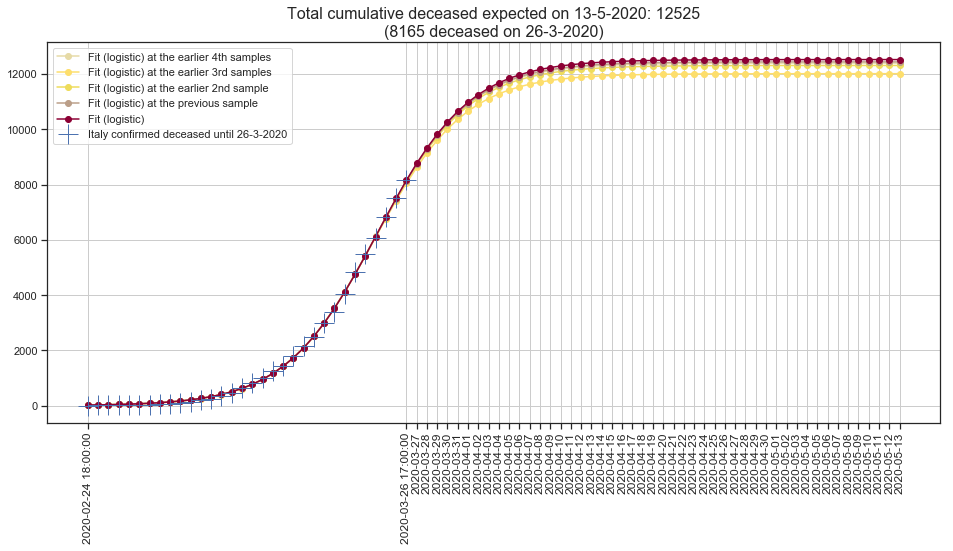

In [19]:
sns.set(style="ticks")

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(111)

# Fit on data
fit_deceased = logistic_funct(x_longer, res_lsq_d.x)
fit_deceased_1 = logistic_funct(x_longer, res_lsq_d_1.x)
fit_deceased_2 = logistic_funct(x_longer, res_lsq_d_2.x)
fit_deceased_3 = logistic_funct(x_longer, res_lsq_d_3.x)
fit_deceased_4 = logistic_funct(x_longer, res_lsq_d_4.x)

ax.plot(x_longer, fit_deceased_4, 'o-', c = sns.xkcd_rgb["beige"], label="Fit (logistic) at the earlier 4th samples")
ax.plot(x_longer, fit_deceased_3, 'o-', c = sns.xkcd_rgb["pale gold"], label="Fit (logistic) at the earlier 3rd samples")
ax.plot(x_longer, fit_deceased_2, 'o-', c = sns.xkcd_rgb["dull yellow"], label="Fit (logistic) at the earlier 2nd sample")
ax.plot(x_longer, fit_deceased_1, 'o-', c = sns.xkcd_rgb["mushroom"], label="Fit (logistic) at the previous sample")
ax.plot(x_longer, fit_deceased, 'o-', c = sns.xkcd_rgb["red wine"], label="Fit (logistic)")
ax.plot(x_data, df['deceduti'], '+', markersize=20, label = f"Italy confirmed deceased until {cases_last_date}")

expected_final = int(np.round(fit_deceased[-1]))
last_confirmed = df['deceduti'][-1]
final_date = df.index[0] + (len(x_longer) - 1) * (df.index[1] - df.index[0])
final_date_fmt = str(final_date.day) + "-" + str(final_date.month) + "-" + str(final_date.year) 
plt.title(f"Total cumulative deceased expected on {final_date_fmt}: {expected_final}\n({last_confirmed} deceased on {cases_last_date})", size=16)
plt.legend()
plt.grid()

future_range = np.arange(len(df), 2.5 * len(df) + 1)
future_range_labels = [str(df.index[0]), str(df.index[-1])]
for dt in pd.date_range(df.index[-1], df.index[-1] + len(future_range) * (df.index[-1] - df.index[-2])):
    if dt > df.index[-1]:
        future_range_labels += [str(dt.year) + "-" + f'{dt.month:02}' + "-" + f'{dt.day:02}']

plt.xticks(ticks = np.concatenate([[1], future_range]),
           labels = future_range_labels,
           rotation = 90, size = 12)